# Train ParticleNet

In [1]:
import glob

import numpy as np

import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader

from itertools import cycle
from sklearn.metrics import roc_curve, auc

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import mplhep as hep

plt.style.use(hep.style.CMS)
plt.rcParams.update({'font.size': 20})

from tqdm.notebook import tqdm

from torch_geometric.explain import Explainer, GNNExplainer

# import xai4hep

## Get dataset

In [32]:
from torch.utils.data import random_split
dataset = torch.load("gnn_dataset_regression.pt")
for i in range(len(dataset)):
    sample = dataset[i]
    sample.x = sample.x.float()  # 转换为 float32
    dataset[i] = sample
dataset_size = len(dataset)
train_dataset, val_dataset, test_dataset = random_split(dataset, [int(0.8 * dataset_size), int(0.1 * dataset_size), int(0.1 * dataset_size)])

C:\Users\Administrator\AppData\Local\Temp\ipykernel_20576\123028539.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load("gnn_dataset_regression.pt")


## Explore dataset

In [33]:
subset_list = list(test_dataset)
for sample in subset_list[:5]:
    print(sample)

Data(x=[42, 7], y=1000.0)
Data(x=[15, 7], y=50.0)
Data(x=[1, 7], y=2000.0)
Data(x=[1, 7], y=500.0)
Data(x=[1, 7], y=1000.0)


In [34]:
test_dataset[1].x

tensor([[-37.3319,   0.0000,  11.9013,  11.9013,  11.9013,  11.9013,  37.3319],
        [ -2.5818,   0.1906,   0.1000,   0.1000,   0.1000,   0.1000,   2.5888],
        [ -2.8788,   0.2585,   0.1000,   0.1000,   0.1000,   0.1000,   2.8904],
        [ -2.8836,   0.2598,   0.1000,   0.1000,   0.1000,   0.1000,   2.8952],
        [ -2.8884,   0.2611,   0.1000,   0.1000,   0.1000,   0.1000,   2.9002],
        [ -2.5825,   0.1870,   0.1000,   0.1000,   0.1000,   0.1000,   2.5892],
        [ -2.8800,   0.2537,   0.1000,   0.1000,   0.1000,   0.1000,   2.8912],
        [ -2.8848,   0.2549,   0.1000,   0.1000,   0.1000,   0.1000,   2.8961],
        [ -2.8897,   0.2562,   0.1000,   0.1000,   0.1000,   0.1000,   2.9010],
        [ -2.4630,   0.3119,   0.1000,   0.1000,   0.1000,   0.1000,   2.4827],
        [ -2.4666,   0.3130,   0.1000,   0.1000,   0.1000,   0.1000,   2.4864],
        [ -2.5030,   0.1331,   0.1000,   0.1000,   0.1000,   0.1000,   2.5065],
        [ -2.5069,   0.1337,   0.1000,  

In [35]:
test_loader = DataLoader(test_dataset, batch_size=128)
val_loader = DataLoader(train_dataset, batch_size=128)

## Get model

In [50]:
# the actual particlenet model can be imported via `xai4hep.particlenet import ParticleNet`
# the model is below is a simplified one

import torch.nn.functional as F
from torch import Tensor
from torch_cluster import knn_graph
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn.conv import MessagePassing, EdgeConv
from torch_geometric.typing import Adj, PairTensor


class EdgeConvBlock(nn.Module):
    def __init__(self, in_size, layer_size, depth):
        super(EdgeConvBlock, self).__init__()

        layers = []

        layers.append(nn.Linear(in_size * 2, layer_size))
        layers.append(nn.BatchNorm1d(layer_size))
        layers.append(nn.ReLU())

        for i in range(depth):
            layers.append(nn.Linear(layer_size, layer_size))
            layers.append(nn.BatchNorm1d(layer_size))
            layers.append(nn.ReLU())

        self.edge_conv = EdgeConv(nn.Sequential(*layers), aggr="mean")

    def forward(self, x, edge_index):
        return self.edge_conv(x, edge_index)


class ParticleNet(nn.Module):
    def __init__(
        self,
        node_feat_size,
        num_classes=1,
        depth=1,
    ):
        super(ParticleNet, self).__init__()

        self.node_feat_size = node_feat_size
        self.num_classes = num_classes

        self.fc_size = 256

        # define the edgeconvblocks
        self.edge_conv_block = EdgeConvBlock(node_feat_size, 256, depth=depth)

        # define the fully connected networks (post-edgeconvs)
        self.fc1 = nn.Linear(node_feat_size + 256, self.fc_size)
        self.fc2 = nn.Linear(self.fc_size, self.num_classes)

        self.sig = nn.Sigmoid()

    def forward(self, x, edge_index, batch=None):
        # input transformations
        x[:, 2] = (x[:, 2] - 1.7) * 0.7  # part_pt_log
        x[:, 3] = (x[:, 3] - 2.0) * 0.7  # part_e_log
        x[:, 4] = (x[:, 4] + 4.7) * 0.7  # part_logptrel
        x[:, 5] = (x[:, 5] + 4.7) * 0.7  # part_logerel
        x[:, 6] = (x[:, 6] - 0.2) * 4.7  # part_deltaR

        # useful placeholders for LRP studies
        out = self.edge_conv_block(x, edge_index)
        x = torch.cat((out, x), dim=1)  # concatenating with latent features i.e. skip connections per EdgeConvBlock

        if batch is None:
            x = x.sum(axis=0)
        else:
            x = global_mean_pool(x, batch)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
#         x = self.sig(x)*(5000) # Currently removed for regression

        return x


# setup the input/output dimension of the model
k = 12

model_kwargs = {
    "node_feat_size": 7,
    "num_classes": 1,
    "depth": 3,
}

model = ParticleNet(**model_kwargs)

In [51]:
# train the model
def train(loader, model, idx=100):
    model.train()
#     criterion = nn.BCELoss()
    criterion = nn.MSELoss() # for regression
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for i, batch in enumerate(loader):
        edge_index = knn_graph(batch.x[:, :2], k, batch.batch)

        preds = model(batch.x, edge_index, batch.batch)

        # compute the invariance loss which is contrained by the other loss terms
        loss = criterion(preds, batch.y.unsqueeze(-1).float())

        # backprop
        for param in model.parameters():
            param.grad = None
        loss.backward()
        optimizer.step()

        optimizer.step()
        if i % 10 == 0:
            print(f"loss on batch {i}: {loss.detach()}")

        if i == idx:
            break


train(val_loader, model, idx=100)

loss on batch 0: 4359700.0
loss on batch 10: 4048991.5
loss on batch 20: 5589926.5
loss on batch 30: 3277007.0
loss on batch 40: 2916140.25
loss on batch 50: 2552634.25
loss on batch 60: 2475973.5
loss on batch 70: 2882793.5
loss on batch 80: 2824681.5
loss on batch 90: 2469975.75
loss on batch 100: 2458592.25


In [38]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


count_parameters(model)

271105

ValueError: multiclass format is not supported

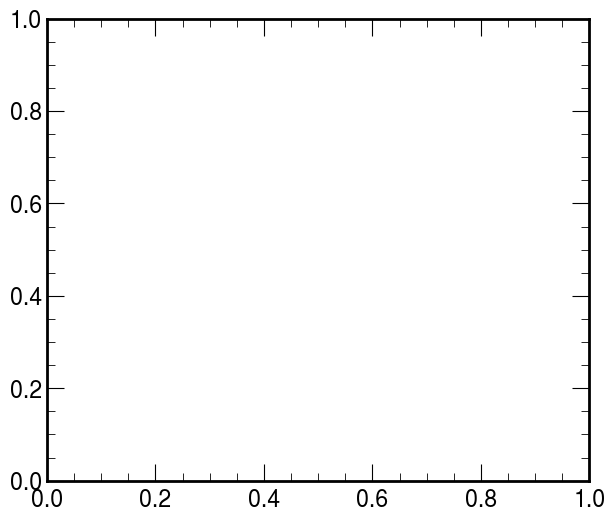

In [39]:
# test
@torch.no_grad()
def test(loader, model, idx=100):
    model.eval()
    targets_ = []
    preds_ = []
    for i, batch in enumerate(loader):
        edge_index = knn_graph(batch.x[:, :2], k)

        preds_ += model(batch.x, edge_index, batch.batch).tolist()
        targets_ += batch.y.tolist()

        if i == idx:
            break
    return preds_, targets_


preds_, targets_ = test(test_loader, model, idx=100)

fig, ax = plt.subplots(figsize=[7, 6])

fpr, tpr, _ = roc_curve(targets_, preds_)
ax.plot(
    tpr,
    fpr,
    color="darkorange",
    lw=2,
    label=f"PN: AUC = {round(auc(fpr, tpr)*100,2)}%",
)

plt.xlim([0.0, 1.0])
plt.ylim([1e-3, 1.0])
plt.ylabel("False positive rate")
plt.xlabel("True positive rate")
plt.yscale("log")
plt.legend()
plt.show()

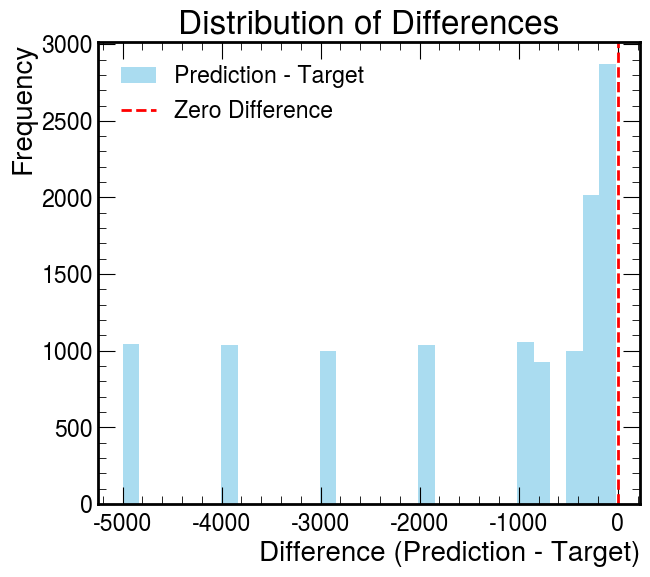

In [49]:
import matplotlib.pyplot as plt

# 定义测试函数
@torch.no_grad()
def test(loader, model, idx=100):
    model.eval()
    targets_ = []
    preds_ = []
    for i, batch in enumerate(loader):
        edge_index = knn_graph(batch.x[:, :2], k)

        preds = model(batch.x, edge_index, batch.batch).squeeze().tolist()  # 确保输出为一维
        targets = batch.y.squeeze().tolist()  # 确保真实值为一维

        if isinstance(preds, float):  # 如果是单个值，直接追加
            preds_ += [preds]
        else:  # 如果是列表，则追加解包后的值
            preds_ += preds

        if isinstance(targets, float):  # 同上
            targets_ += [targets]
        else:
            targets_ += targets

        if i == idx:
            break
    return preds_, targets_


# 获取预测值和真实值
preds_, targets_ = test(test_loader, model, idx=100)

# 计算差值
differences = [pred - target for pred, target in zip(preds_, targets_)]

# 绘制差值分布图
fig, ax = plt.subplots(figsize=[7, 6])
ax.hist(differences, bins=30, color='skyblue', alpha=0.7, label='Prediction - Target')
ax.axvline(0, color='red', linestyle='dashed', linewidth=2, label='Zero Difference')

# 添加图例和标签
plt.xlabel('Difference (Prediction - Target)')
plt.ylabel('Frequency')
plt.title('Distribution of Differences')
plt.legend()
plt.show()


## Run real training

In [26]:
! python -m xai4hep.particlenet.run_training --quick --model_prefix=ParticleNet_model --dataset /global/cfs/cdirs/ntrain2/data/toptagging --outpath $PWD/experiments

Device 0: NVIDIA A100-SXM4-40GB
Device 1: NVIDIA A100-SXM4-40GB
Device 2: NVIDIA A100-SXM4-40GB
Device 3: NVIDIA A100-SXM4-40GB
ParticleNet(
  (edge_conv_blocks): ModuleList(
    (0): EdgeConvBlock(
      (edge_conv): EdgeConv_lrp(nn=Sequential(
        (0): Linear(in_features=14, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=64, out_features=64, bias=True)
        (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      ))
    )
    (1): EdgeConvBlock(
      (edge_conv): EdgeConv_lrp(nn=Sequential(
        (0): Linear(in_features=142, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=128, out_features=128, bias=True)
        (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, 

## Calculate LRP scores

In [27]:
! python -m xai4hep.run_lrp_particlenet --quick --model_prefix=ParticleNet_model --run_lrp --make_dr_Mij_plots --scaling_up --dataset /global/cfs/cdirs/ntrain2/data/toptagging --outpath $PWD/experiments

Will use GPU model: NVIDIA A100-SXM4-40GB
Runing the LRP pipeline to compute the Rscores for the model at epoch -1
- loading datafiles for lrp studies...
--- loading only 1000 events for quick test
ParticleNet(
  (edge_conv_blocks): ModuleList(
    (0): EdgeConvBlock(
      (edge_conv): EdgeConv_lrp(nn=Sequential(
        (0): Linear(in_features=14, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=64, out_features=64, bias=True)
        (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      ))
    )
    (1): EdgeConvBlock(
      (edge_conv): EdgeConv_lrp(nn=Sequential(
        (0): Linear(in_features=142, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=128, out_features=128, bias=True